# Neural collaborative filtering - Keras

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print('TensorFlow Version: {}'.format(tf.__version__))

Found GPU at: /device:GPU:0
TensorFlow Version: 1.14.0-rc1


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from keras import backend as K
from keras.regularizers import l1, l2, l1_l2
from keras.models import Model
from keras.layers import (Embedding, Input, Dense, Reshape, Flatten, Dropout,
                          BatchNormalization, Lambda, Activation,
                          Multiply, Concatenate, Dot)
from keras.optimizers import Adagrad, Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


## Reading dataset

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [0]:
df = pd.read_csv("gdrive/My Drive/Colab Notebooks/data/ratings.csv")
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [0]:
# Convert ordinals to categories
df['userId'] = df['userId'].astype('category').cat.codes.values
df['movieId'] = df['movieId'].astype('category').cat.codes.values
df.head()

,userId,movieId,rating,timestamp
0,0,0,4.0,964982703
1,0,2,4.0,964981247
2,0,5,4.0,964982224
3,0,43,5.0,964983815
4,0,46,5.0,964982931


In [0]:
num_users, num_items = len(df['userId'].unique()), len(df['movieId'].unique())
print('Number of users = {}\nNumber of items = {}'.format(num_users, num_items))

Number of users = 610
Number of items = 9724


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df, test_size=0.2)

## Main

In [0]:
def get_model(num_users, num_items, mf_dim=10, layers=[10], reg_layers=[0], reg_mf=0):
    assert len(layers) == len(reg_layers)
    num_layer = len(layers) #Number of layers in the MLP
    
    # Input variables
    user_input = Input(shape=[1], dtype='int32', name='user_input')
    item_input = Input(shape=[1], dtype='int32', name='item_input')
    
    # Embedding layer
    MF_Embedding_User = Embedding(
        input_dim=num_users+1, output_dim=mf_dim, name='mf_embedding_user',
        embeddings_initializer='random_normal', activity_regularizer=l2(reg_mf),
        input_length=1)
    MF_Embedding_Item = Embedding(
        input_dim=num_items+1, output_dim=mf_dim, name='mf_embedding_item',
        embeddings_initializer='random_normal', activity_regularizer=l2(reg_mf),
        input_length=1)   

    mlp_dim = layers[0] // 2
    MLP_Embedding_User = Embedding(
        input_dim=num_users+1, output_dim=mlp_dim, name='mlp_embedding_user',
        embeddings_initializer='random_normal', activity_regularizer=l2(reg_layers[0]),
        input_length=1)
    MLP_Embedding_Item = Embedding(
        input_dim=num_items+1, output_dim=mlp_dim, name='mlp_embedding_item',
        embeddings_initializer='random_normal', activity_regularizer=l2(reg_layers[0]),
        input_length=1)   
    
    # MF part
    mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
    mf_vector = Multiply()([mf_user_latent, mf_item_latent]) # element-wise multiply

    # MLP part 
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    mlp_vector = Concatenate()([mlp_user_latent, mlp_item_latent])
    for idx in range(1, num_layer):
        layer = Dense(layers[idx], kernel_regularizer=l2(reg_layers[idx]),
                      activation='relu', name="layer%d" %idx)
        mlp_vector = layer(mlp_vector)

    # Concatenate MF and MLP parts
    #mf_vector = Lambda(lambda x: x * alpha)(mf_vector)
    #mlp_vector = Lambda(lambda x : x * (1-alpha))(mlp_vector)
    predict_vector = Concatenate()([mf_vector, mlp_vector])
    
    # Final prediction layer
    prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform',
                       name="prediction")(predict_vector)
    
    model = Model(inputs=[user_input, item_input], outputs=prediction)
    
    return model

In [0]:
mf_dim = 20
layers = [64,32,16,8]
reg_layers = [0,0,0,0]
reg_mf = 0


model = get_model(num_users, num_items, mf_dim, layers, reg_layers, reg_mf)
# model.compile(optimizer=Adam(lr=0.001), loss='mean_absolute_error')
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
mlp_embedding_user (Embedding)  (None, 1, 32)        19552       user_input[0][0]                 
__________________________________________________________________________________________________
mlp_embedding_item (Embedding)  (None, 1, 32)        311200      item_input[0][0]                 
__________________________________________________________________________________________________
flatten_11

In [0]:
batch_size = 64
epochs = 10

file_path = 'neumf_model1.h5'
checkpoint = ModelCheckpoint(
    file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', mode='min', patience=5)
callbacks_list = [checkpoint, early]


# y_train = X_train['rating'].values
# y_test = X_test['rating'].values


y_train = (X_train['rating'].values > 4).astype(int)
y_test = (X_test['rating'].values > 4).astype(int)


history = model.fit(
    [X_train['userId'], X_train['movieId']], y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=([X_test['userId'], X_test['movieId']], y_test),
    callbacks=callbacks_list
)

Train on 80668 samples, validate on 20168 samples
Epoch 1/10
80668/80668 [==============================] - 11s 131us/step - loss: 0.5629 - acc: 0.7783 - val_loss: 0.4707 - val_acc: 0.7822

Epoch 00001: val_loss improved from inf to 0.47070, saving model to neumf_model1.h5
Epoch 2/10
80668/80668 [==============================] - 10s 126us/step - loss: 0.4454 - acc: 0.7916 - val_loss: 0.4377 - val_acc: 0.8013

Epoch 00002: val_loss improved from 0.47070 to 0.43768, saving model to neumf_model1.h5
Epoch 3/10
80668/80668 [==============================] - 10s 126us/step - loss: 0.4133 - acc: 0.8095 - val_loss: 0.4294 - val_acc: 0.8048

Epoch 00003: val_loss improved from 0.43768 to 0.42940, saving model to neumf_model1.h5
Epoch 4/10
80668/80668 [==============================] - 10s 126us/step - loss: 0.3965 - acc: 0.8156 - val_loss: 0.4301 - val_acc: 0.8035

Epoch 00004: val_loss did not improve from 0.42940
Epoch 5/10
80668/80668 [==============================] - 10s 126us/step - loss

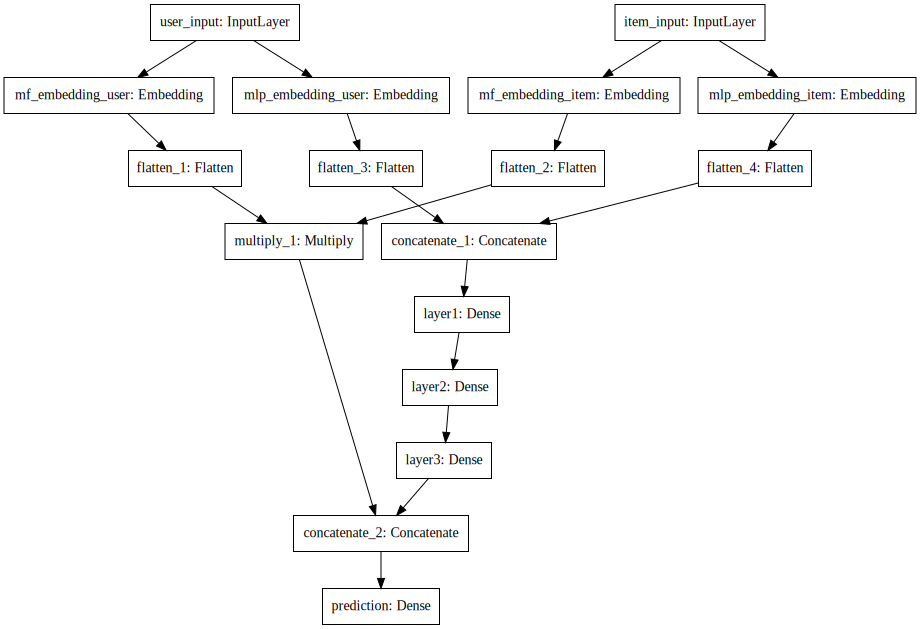

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,  show_shapes=False, show_layer_names=True, rankdir='HB')
    .create(prog='dot', format='svg'))

In [0]:
def get_model2(n_users, n_items, n_latent_user, n_latent_item, n_latent_mf):
    
    item_input = Input(shape=[1],name='Item')
    item_embedding_mlp = Embedding(n_items + 1, n_latent_item, name='Item-Embedding-MLP')(item_input)
    item_vec_mlp = Flatten()(item_embedding_mlp)
    item_vec_mlp = Dropout(0.2)(item_vec_mlp)

    item_embedding_mf = Embedding(n_items + 1, n_latent_mf, name='Item-Embedding-MF')(item_input)
    item_vec_mf = Flatten()(item_embedding_mf)
    item_vec_mf = Dropout(0.2)(item_vec_mf)

    user_input = Input(shape=[1],name='User')
    user_embedding_mlp = Embedding(n_users + 1, n_latent_user, name='User-Embedding-MLP')(user_input)
    user_vec_mlp = Flatten()(user_embedding_mlp)
    user_vec_mlp = Dropout(0.2)(user_vec_mlp)

    user_embedding_mf = Embedding(n_users + 1, n_latent_mf, name='User-Embedding-MF')(user_input)
    user_vec_mf = Flatten()(user_embedding_mf)
    user_vec_mf = Dropout(0.2)(user_vec_mf)


    mlp = Concatenate()([item_vec_mlp, user_vec_mlp])
    mlp = Dropout(0.2)(mlp)
    mlp = Dense(200)(mlp)
    mlp = BatchNormalization()(mlp)
    mlp = Dropout(0.2)(mlp)
    mlp = Dense(100)(mlp)
    mlp = BatchNormalization()(mlp)
    mlp = Dropout(0.2)(mlp)
    mlp = Dense(50)(mlp)
    mlp = Dense(20, activation='relu')(mlp)
    pred_mlp = Dense(1, activation='relu')(mlp)

    pred_mf = Dot(axes=1, normalize=False)([item_vec_mf, user_vec_mf])

    combine_mlp_mf = Concatenate()([pred_mf, pred_mlp])
    result_combine = Dense(100)(combine_mlp_mf)
    deep_combine = Dense(100)(result_combine)

    result = Dense(1)(deep_combine)

    model = Model([user_input, item_input], result)
    return model

In [0]:
mf_dim = 20
n_latent_user = 32
n_latent_item = 32


model = get_model2(num_users, num_items, n_latent_user, n_latent_item, n_latent_mf=mf_dim)
# model.compile(optimizer=Adam(lr=0.01), loss='mean_absolute_error')
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Item-Embedding-MLP (Embedding)  (None, 1, 32)        311200      Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding-MLP (Embedding)  (None, 1, 32)        19552       User[0][0]                       
__________________________________________________________________________________________________
flatten_25

In [0]:
batch_size = 64
epochs = 10

file_path = 'neumf_model2.h5'
checkpoint = ModelCheckpoint(
    file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', mode='min', patience=5)
callbacks_list = [checkpoint, early]


# y_train = X_train['rating'].values
# y_test = X_test['rating'].values


y_train = (X_train['rating'].values > 4).astype(int)
y_test = (X_test['rating'].values > 4).astype(int)


history = model.fit(
    [X_train['userId'], X_train['movieId']], y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=([X_test['userId'], X_test['movieId']], y_test),
    callbacks=callbacks_list
)

Train on 80668 samples, validate on 20168 samples
Epoch 1/10
80668/80668 [==============================] - 21s 260us/step - loss: 0.5218 - acc: 0.7836 - val_loss: 0.4935 - val_acc: 0.7825

Epoch 00001: val_loss improved from inf to 0.49351, saving model to neumf_model2.h5
Epoch 2/10
80668/80668 [==============================] - 19s 240us/step - loss: 0.4681 - acc: 0.7945 - val_loss: 0.5101 - val_acc: 0.7892

Epoch 00002: val_loss did not improve from 0.49351
Epoch 3/10
80668/80668 [==============================] - 19s 238us/step - loss: 0.4153 - acc: 0.8108 - val_loss: 0.4798 - val_acc: 0.7952

Epoch 00003: val_loss improved from 0.49351 to 0.47980, saving model to neumf_model2.h5
Epoch 4/10
80668/80668 [==============================] - 19s 238us/step - loss: 0.3777 - acc: 0.8217 - val_loss: 0.6178 - val_acc: 0.7761

Epoch 00004: val_loss did not improve from 0.47980
Epoch 5/10
80668/80668 [==============================] - 19s 238us/step - loss: 0.3591 - acc: 0.8099 - val_loss: 0.